## ML Configuration

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

tqdm.pandas()

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [4]:
SEED = 23
data_dir = Path("Data/data_to_use")
unseen_data_dir = Path("Data/TUD")

In [5]:
conf_ML = [
    ('Dummy', DummyClassifier(), {'Dummy__strategy' : ["stratified"], 'Dummy__random_state': [SEED]}),
    ('Tree', DecisionTreeClassifier(), {'Tree__max_depth': range(1,10), 'Tree__random_state': [SEED]}),
    ('Forest', RandomForestClassifier(), {'Forest__max_depth': range(1,20), 'Forest__random_state': [SEED]}),
    ('GradientBoost', GradientBoostingClassifier(), {'GradientBoost__max_depth': range(1,10), 'GradientBoost__random_state': [SEED]}),
    ('MLP', MLPClassifier(), {'MLP__hidden_layer_sizes': range(1,20), "MLP__random_state": [SEED]}),
    ('Logistic', LogisticRegression(), {'Logistic__C':np.logspace(0,4, 10) ,'Logistic__random_state': [SEED]}),
    ('SVM', SVC(), {'SVM__C' : np.logspace(0,4, 20), 'SVM__gamma': np.logspace(-1,1, 10), 'SVM__kernel' : ['rbf'], 'SVM__random_state': [SEED]})
]

In [6]:
features_ML = ["CV", "SPD", "DIFFP", "RD", "KURT", "SKEW", "KSTEST"]

# Train

## Definitions

In [145]:
def prepare_data(name, features = features_ML, return_industry =False):
    
    #datanames = [ "brazil_gaz", "japan", "brazil", "ticino", "US"]
    
    #if name not in datanames + ["all"]:
        #print("This is not a dataset ")
        
    if type(name) == list:
    ##TODO: eventually use full dataset not only train here    
        data = []
        for ds in tqdm(name):
            if ds != "swissdata":
                df = pd.read_json(data_dir/f"{ds}_train.json")
            else:
                df = pd.read_json(data_dir/f"{ds}_train.json")
            if "ID" in df.keys():
                df.rename(columns = {"ID": "Tender"}, inplace = True)
            if "Price" in df.keys():
                df.rename(columns = {"Price": "Bid_value"}, inplace = True)
            if "complete" in df.keys(): #complete/incomplete is just a case in Swiss dataset, take care of it later
                #df.rename(columns = {"complete": "Collusive_competitor"}, inplace = True)#this option only considers complete cartels as cartels
                #df["cartel"] = df.complete | df.incomplete #this option also considers incomplete cartels as cartels
                df = df[df.incomplete!=1] #this option removes all incomplete cartels and does not consider them
                df.rename(columns = {"complete": "Collusive_competitor"}, inplace = True)
                
            df["Tender"] = df.Tender.apply(lambda s: f"{ds}/{s}" )
            
            if return_industry:
                df["industry"] = ds
            
            data.append(df[list(set(features + ["Number_bids"])) + ["Bid_value", "Tender", "Collusive_competitor"]]) #to make sure Number_bids is included as it will be needed later
        df = pd.concat(data)
        
        
        
    else:
        print("for this evaluation we need a list as input")
    
    df_grouped = df.groupby(by="Tender").head(1).reset_index()
    
    df_grouped.drop(columns=["Bid_value"], inplace = True)
    df_grouped = df_grouped.merge(df.groupby(by="Tender")["Bid_value"].apply(list), left_on = "Tender", right_on = "Tender")
    
    df_grouped["Bid_value"] = df_grouped.Bid_value.apply(lambda x: (np.asarray(x)-min(np.asarray(x)))/np.std(np.asarray(x)))
    df_grouped["Bid_value"] = df_grouped.Bid_value.apply(lambda x: np.sort(x)[::-1])
    
    padding_length = max(np.asarray(df_grouped.Number_bids.tolist()))
    df_grouped["Bid_value"] = df_grouped.Bid_value.apply(lambda x: np.pad(x, (0,padding_length-len(x))))
    
    df_grouped.dropna(inplace = True)
    
    X_DL = np.array(df_grouped.Bid_value.tolist())
    X_DL = X_DL.reshape(X_DL.shape[0], X_DL.shape[1], 1)

    X = df_grouped[features]
    y = df_grouped["Collusive_competitor"]
    
    return X,y, X_DL

In [146]:
def evaluate_models(X,y, configuration, SEED = SEED, print_full = False, LOO = False):
    model_scores = []
    models = []
    results = []
    full_results = []
    for name, algo, params in configuration:
        print(f'Trying {name} ...')
        # Extend model with normalisation step (here we use z-normalisation)
        #("scaler", StandardScaler()) # only needed in ML hyper parameter tuning
        pipeline = Pipeline([("scaler", StandardScaler()),(name, algo)])
        # Instantiate grid search object and pass params, number of folds and scoring-function
        if LOO:
            mycv = StratifiedKFold(n_splits = 10, random_state=SEED, shuffle = True) #not programmed yet
        else:
            mycv = StratifiedKFold(n_splits = 10, random_state=SEED, shuffle = True)
        classifier = GridSearchCV(pipeline, param_grid=params, cv= mycv, scoring=['f1', 'precision', 'recall', 'accuracy'], refit = 'f1', return_train_score = True)
        # Fit cross validation to our training data: within this function, all configurations are tried
        classifier.fit(X, y)
        print(f'  - Best hyperparameter: {classifier.best_params_}')
        print(f'  - Best F1 score: {classifier.best_score_:.3f}')
        if print_full:
            print(f'  - F1 Result for each parametrization in train:', [f'{x:.2f}' for x in classifier.cv_results_['mean_train_f1']])
            print(f'  - F1 Result for each parametrization in test:', [f'{x:.2f}' for x in classifier.cv_results_['mean_test_f1']])
            print(f'  - precision Result for each parametrization in train:', [f'{x:.2f}' for x in classifier.cv_results_['mean_train_precision']])
            print(f'  - precision for each parametrization in test:', [f'{x:.2f}' for x in classifier.cv_results_['mean_test_precision']])
            print(f'  - recall Result for each parametrization in train:', [f'{x:.2f}' for x in classifier.cv_results_['mean_train_recall']])
            print(f'  - recall Result for each parametrization in test:', [f'{x:.2f}' for x in classifier.cv_results_['mean_test_recall']])
            print(f'  - accuracy Result for each parametrization in train:', [f'{x:.2f}' for x in classifier.cv_results_['mean_train_accuracy']])
            print(f'  - accuracy Result for each parametrization in test:', [f'{x:.2f}' for x in classifier.cv_results_['mean_test_accuracy']])
        model_scores.append(classifier.best_score_)
        models.append(classifier.best_estimator_)
    
        index = classifier.best_index_
        df_results = pd.DataFrame({
            "algorithm": name,
            "train_f1": ["{:.3f}".format(classifier.cv_results_['mean_train_f1'][index])], "test_f1": ["{:.3f}".format(classifier.cv_results_['mean_test_f1'][index])],
            "train_precision": ["{:.3f}".format(classifier.cv_results_['mean_train_precision'][index])], "test_precision": ["{:.3f}".format(classifier.cv_results_['mean_test_precision'][index])],
            "train_recall": ["{:.3f}".format(classifier.cv_results_['mean_train_recall'][index])], "test_recall": ["{:.3f}".format(classifier.cv_results_['mean_test_recall'][index])],
            "train_accuracy": ["{:.3f}".format(classifier.cv_results_['mean_train_accuracy'][index])], "test_accuracy": ["{:.3f}".format(classifier.cv_results_['mean_test_accuracy'][index])],
            "params": [classifier.best_params_]
            })
        results.append(df_results)
    
        df_full_results = pd.DataFrame({
            "algorithm": name,
            "train_f1": classifier.cv_results_['mean_train_f1'], "test_f1": classifier.cv_results_['mean_test_f1'],
            "train_precision": classifier.cv_results_['mean_train_precision'], "test_precision": classifier.cv_results_['mean_test_precision'],
            "train_recall": classifier.cv_results_['mean_train_recall'], "test_recall": classifier.cv_results_['mean_test_recall'],
            "train_accuracy": classifier.cv_results_['mean_train_accuracy'], "test_accuracy": classifier.cv_results_['mean_test_accuracy'],
            "params": classifier.cv_results_["params"]
            })
        full_results.append(df_full_results)
    
    results = pd.concat(results)
    results = results.reset_index(drop = True)

    full_results = pd.concat(full_results)
    full_results = full_results.reset_index(drop = True)
    
    return results, full_results

## Experiment 7 (Swiss[1]-Swiss[2]):

Swiss time period 1 for training, Swiss time period 2 for evaluation.

In [149]:
data_names = ["swiss1"]

In [150]:
X,y,_ = prepare_data(data_names)
results, full_results = evaluate_models(X, y, conf_ML, SEED = SEED)
results.to_json("MLresults/MLreanalysis/exp7_nbids_comp.json")
full_results.to_json("MLresults/MLreanalysis/exp7_nbids_fullresults_comp.json")

  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_2236328/1521300152.py:44: RuntimeWarning: invalid value encountered in divide
  df_grouped["Bid_value"] = df_grouped.Bid_value.apply(lambda x: (np.asarray(x)-min(np.asarray(x)))/np.std(np.asarray(x)))


Trying Dummy ...
  - Best hyperparameter: {'Dummy__random_state': 23, 'Dummy__strategy': 'stratified'}
  - Best F1 score: 0.753
Trying Tree ...
  - Best hyperparameter: {'Tree__max_depth': 1, 'Tree__random_state': 23}
  - Best F1 score: 0.866
Trying Forest ...
  - Best hyperparameter: {'Forest__max_depth': 5, 'Forest__random_state': 23}
  - Best F1 score: 0.870
Trying GradientBoost ...
  - Best hyperparameter: {'GradientBoost__max_depth': 1, 'GradientBoost__random_state': 23}
  - Best F1 score: 0.869
Trying MLP ...


/home/qstaudinger/.conda/envs/collusion_ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/qstaudinger/.conda/envs/collusion_ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/qstaudinger/.conda/envs/collusion_ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/qstaudinger/.conda/envs/collusion_ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

  - Best hyperparameter: {'MLP__hidden_layer_sizes': 1, 'MLP__random_state': 23}
  - Best F1 score: 0.866
Trying Logistic ...
  - Best hyperparameter: {'Logistic__C': np.float64(59.94842503189409), 'Logistic__random_state': 23}
  - Best F1 score: 0.863
Trying SVM ...
  - Best hyperparameter: {'SVM__C': np.float64(1.0), 'SVM__gamma': np.float64(5.994842503189409), 'SVM__kernel': 'rbf', 'SVM__random_state': 23}
  - Best F1 score: 0.867


In [151]:
results

,algorithm,train_f1,test_f1,train_precision,test_precision,train_recall,test_recall,train_accuracy,test_accuracy,params
0,Dummy,0.764,0.753,0.762,0.755,0.766,0.752,0.638,0.624,"{'Dummy__random_state': 23, 'Dummy__strategy':..."
1,Tree,0.866,0.866,0.764,0.764,1.000,1.000,0.764,0.764,"{'Tree__max_depth': 1, 'Tree__random_state': 23}"
2,Forest,0.883,0.870,0.794,0.780,0.994,0.986,0.799,0.776,"{'Forest__max_depth': 5, 'Forest__random_state..."
3,GradientBoost,0.871,0.869,0.773,0.772,0.996,0.994,0.774,0.772,"{'GradientBoost__max_depth': 1, 'GradientBoost..."
4,MLP,0.866,0.866,0.764,0.764,1.000,1.000,0.764,0.764,"{'MLP__hidden_layer_sizes': 1, 'MLP__random_st..."
5,Logistic,0.864,0.863,0.767,0.766,0.989,0.989,0.762,0.761,"{'Logistic__C': 59.94842503189409, 'Logistic__..."
6,SVM,0.916,0.867,0.852,0.779,0.990,0.976,0.861,0.770,"{'SVM__C': 1.0, 'SVM__gamma': 5.99484250318940..."


In [152]:
print(results.to_latex(index=False))  

\begin{tabular}{llllllllll}
\toprule
algorithm & train_f1 & test_f1 & train_precision & test_precision & train_recall & test_recall & train_accuracy & test_accuracy & params \\
\midrule
Dummy & 0.764 & 0.753 & 0.762 & 0.755 & 0.766 & 0.752 & 0.638 & 0.624 & {'Dummy__random_state': 23, 'Dummy__strategy': 'stratified'} \\
Tree & 0.866 & 0.866 & 0.764 & 0.764 & 1.000 & 1.000 & 0.764 & 0.764 & {'Tree__max_depth': 1, 'Tree__random_state': 23} \\
Forest & 0.883 & 0.870 & 0.794 & 0.780 & 0.994 & 0.986 & 0.799 & 0.776 & {'Forest__max_depth': 5, 'Forest__random_state': 23} \\
GradientBoost & 0.871 & 0.869 & 0.773 & 0.772 & 0.996 & 0.994 & 0.774 & 0.772 & {'GradientBoost__max_depth': 1, 'GradientBoost__random_state': 23} \\
MLP & 0.866 & 0.866 & 0.764 & 0.764 & 1.000 & 1.000 & 0.764 & 0.764 & {'MLP__hidden_layer_sizes': 1, 'MLP__random_state': 23} \\
Logistic & 0.864 & 0.863 & 0.767 & 0.766 & 0.989 & 0.989 & 0.762 & 0.761 & {'Logistic__C': np.float64(59.94842503189409), 'Logistic__random_state':

## Experiment 8 (Swiss[2]-Swiss[2]):

Swiss time period 2 for training, Swiss time period 2 for evaluation.

In [153]:
data_names = ["swiss1"]

In [154]:
X,y,_ = prepare_data(data_names)
results, full_results = evaluate_models(X, y, conf_ML, SEED = SEED)
results.to_json("MLresults/MLreanalysis/exp8_nbids_comp.json")
full_results.to_json("MLresults/MLreanalysis/exp8_nbids_fullresults_comp.json")

  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_2236328/1521300152.py:44: RuntimeWarning: invalid value encountered in divide
  df_grouped["Bid_value"] = df_grouped.Bid_value.apply(lambda x: (np.asarray(x)-min(np.asarray(x)))/np.std(np.asarray(x)))


Trying Dummy ...
  - Best hyperparameter: {'Dummy__random_state': 23, 'Dummy__strategy': 'stratified'}
  - Best F1 score: 0.753
Trying Tree ...
  - Best hyperparameter: {'Tree__max_depth': 1, 'Tree__random_state': 23}
  - Best F1 score: 0.866
Trying Forest ...
  - Best hyperparameter: {'Forest__max_depth': 5, 'Forest__random_state': 23}
  - Best F1 score: 0.870
Trying GradientBoost ...
  - Best hyperparameter: {'GradientBoost__max_depth': 1, 'GradientBoost__random_state': 23}
  - Best F1 score: 0.869
Trying MLP ...


/home/qstaudinger/.conda/envs/collusion_ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/qstaudinger/.conda/envs/collusion_ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/qstaudinger/.conda/envs/collusion_ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/qstaudinger/.conda/envs/collusion_ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

  - Best hyperparameter: {'MLP__hidden_layer_sizes': 1, 'MLP__random_state': 23}
  - Best F1 score: 0.866
Trying Logistic ...
  - Best hyperparameter: {'Logistic__C': np.float64(59.94842503189409), 'Logistic__random_state': 23}
  - Best F1 score: 0.863
Trying SVM ...
  - Best hyperparameter: {'SVM__C': np.float64(1.0), 'SVM__gamma': np.float64(5.994842503189409), 'SVM__kernel': 'rbf', 'SVM__random_state': 23}
  - Best F1 score: 0.867


In [155]:
results

,algorithm,train_f1,test_f1,train_precision,test_precision,train_recall,test_recall,train_accuracy,test_accuracy,params
0,Dummy,0.764,0.753,0.762,0.755,0.766,0.752,0.638,0.624,"{'Dummy__random_state': 23, 'Dummy__strategy':..."
1,Tree,0.866,0.866,0.764,0.764,1.000,1.000,0.764,0.764,"{'Tree__max_depth': 1, 'Tree__random_state': 23}"
2,Forest,0.883,0.870,0.794,0.780,0.994,0.986,0.799,0.776,"{'Forest__max_depth': 5, 'Forest__random_state..."
3,GradientBoost,0.871,0.869,0.773,0.772,0.996,0.994,0.774,0.772,"{'GradientBoost__max_depth': 1, 'GradientBoost..."
4,MLP,0.866,0.866,0.764,0.764,1.000,1.000,0.764,0.764,"{'MLP__hidden_layer_sizes': 1, 'MLP__random_st..."
5,Logistic,0.864,0.863,0.767,0.766,0.989,0.989,0.762,0.761,"{'Logistic__C': 59.94842503189409, 'Logistic__..."
6,SVM,0.916,0.867,0.852,0.779,0.990,0.976,0.861,0.770,"{'SVM__C': 1.0, 'SVM__gamma': 5.99484250318940..."


In [156]:
print(results.to_latex(index=False))  

\begin{tabular}{llllllllll}
\toprule
algorithm & train_f1 & test_f1 & train_precision & test_precision & train_recall & test_recall & train_accuracy & test_accuracy & params \\
\midrule
Dummy & 0.764 & 0.753 & 0.762 & 0.755 & 0.766 & 0.752 & 0.638 & 0.624 & {'Dummy__random_state': 23, 'Dummy__strategy': 'stratified'} \\
Tree & 0.866 & 0.866 & 0.764 & 0.764 & 1.000 & 1.000 & 0.764 & 0.764 & {'Tree__max_depth': 1, 'Tree__random_state': 23} \\
Forest & 0.883 & 0.870 & 0.794 & 0.780 & 0.994 & 0.986 & 0.799 & 0.776 & {'Forest__max_depth': 5, 'Forest__random_state': 23} \\
GradientBoost & 0.871 & 0.869 & 0.773 & 0.772 & 0.996 & 0.994 & 0.774 & 0.772 & {'GradientBoost__max_depth': 1, 'GradientBoost__random_state': 23} \\
MLP & 0.866 & 0.866 & 0.764 & 0.764 & 1.000 & 1.000 & 0.764 & 0.764 & {'MLP__hidden_layer_sizes': 1, 'MLP__random_state': 23} \\
Logistic & 0.864 & 0.863 & 0.767 & 0.766 & 0.989 & 0.989 & 0.762 & 0.761 & {'Logistic__C': np.float64(59.94842503189409), 'Logistic__random_state':

## Experiment 9 (Swiss-Swiss[2]):

Swiss complete set for training, Swiss time period 2 for evaluation.

In [157]:
data_names = ["swiss"]

In [159]:
X,y,_ = prepare_data(data_names)
results, full_results = evaluate_models(X, y, conf_ML, SEED = SEED)
results.to_json("MLresults/MLreanalysis/exp9_nbids_comp.json")
full_results.to_json("MLresults/MLreanalysis/exp9_nbids_fullresults_comp.json")

  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_2236328/1521300152.py:44: RuntimeWarning: invalid value encountered in divide
  df_grouped["Bid_value"] = df_grouped.Bid_value.apply(lambda x: (np.asarray(x)-min(np.asarray(x)))/np.std(np.asarray(x)))


Trying Dummy ...
  - Best hyperparameter: {'Dummy__random_state': 23, 'Dummy__strategy': 'stratified'}
  - Best F1 score: 0.741
Trying Tree ...
  - Best hyperparameter: {'Tree__max_depth': 3, 'Tree__random_state': 23}
  - Best F1 score: 0.849
Trying Forest ...
  - Best hyperparameter: {'Forest__max_depth': 3, 'Forest__random_state': 23}
  - Best F1 score: 0.853
Trying GradientBoost ...
  - Best hyperparameter: {'GradientBoost__max_depth': 1, 'GradientBoost__random_state': 23}
  - Best F1 score: 0.853
Trying MLP ...


/home/qstaudinger/.conda/envs/collusion_ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/qstaudinger/.conda/envs/collusion_ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/qstaudinger/.conda/envs/collusion_ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/qstaudinger/.conda/envs/collusion_ml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

  - Best hyperparameter: {'MLP__hidden_layer_sizes': 1, 'MLP__random_state': 23}
  - Best F1 score: 0.848
Trying Logistic ...
  - Best hyperparameter: {'Logistic__C': np.float64(1.0), 'Logistic__random_state': 23}
  - Best F1 score: 0.848
Trying SVM ...
  - Best hyperparameter: {'SVM__C': np.float64(1.6237767391887217), 'SVM__gamma': np.float64(0.16681005372000587), 'SVM__kernel': 'rbf', 'SVM__random_state': 23}
  - Best F1 score: 0.849


In [160]:
results

,algorithm,train_f1,test_f1,train_precision,test_precision,train_recall,test_recall,train_accuracy,test_accuracy,params
0,Dummy,0.738,0.741,0.736,0.734,0.741,0.749,0.614,0.615,"{'Dummy__random_state': 23, 'Dummy__strategy':..."
1,Tree,0.853,0.849,0.758,0.754,0.976,0.970,0.752,0.745,"{'Tree__max_depth': 3, 'Tree__random_state': 23}"
2,Forest,0.856,0.853,0.752,0.749,0.992,0.989,0.753,0.748,"{'Forest__max_depth': 3, 'Forest__random_state..."
3,GradientBoost,0.856,0.853,0.756,0.754,0.986,0.983,0.756,0.751,"{'GradientBoost__max_depth': 1, 'GradientBoost..."
4,MLP,0.848,0.848,0.736,0.736,1.000,1.000,0.736,0.736,"{'MLP__hidden_layer_sizes': 1, 'MLP__random_st..."
5,Logistic,0.849,0.848,0.737,0.737,1.000,0.999,0.737,0.736,"{'Logistic__C': 1.0, 'Logistic__random_state':..."
6,SVM,0.853,0.849,0.755,0.751,0.979,0.976,0.751,0.744,"{'SVM__C': 1.6237767391887217, 'SVM__gamma': 0..."


In [161]:
print(results.to_latex(index=False))  

\begin{tabular}{llllllllll}
\toprule
algorithm & train_f1 & test_f1 & train_precision & test_precision & train_recall & test_recall & train_accuracy & test_accuracy & params \\
\midrule
Dummy & 0.738 & 0.741 & 0.736 & 0.734 & 0.741 & 0.749 & 0.614 & 0.615 & {'Dummy__random_state': 23, 'Dummy__strategy': 'stratified'} \\
Tree & 0.853 & 0.849 & 0.758 & 0.754 & 0.976 & 0.970 & 0.752 & 0.745 & {'Tree__max_depth': 3, 'Tree__random_state': 23} \\
Forest & 0.856 & 0.853 & 0.752 & 0.749 & 0.992 & 0.989 & 0.753 & 0.748 & {'Forest__max_depth': 3, 'Forest__random_state': 23} \\
GradientBoost & 0.856 & 0.853 & 0.756 & 0.754 & 0.986 & 0.983 & 0.756 & 0.751 & {'GradientBoost__max_depth': 1, 'GradientBoost__random_state': 23} \\
MLP & 0.848 & 0.848 & 0.736 & 0.736 & 1.000 & 1.000 & 0.736 & 0.736 & {'MLP__hidden_layer_sizes': 1, 'MLP__random_state': 23} \\
Logistic & 0.849 & 0.848 & 0.737 & 0.737 & 1.000 & 0.999 & 0.737 & 0.736 & {'Logistic__C': np.float64(1.0), 'Logistic__random_state': 23} \\
SVM & 

# Test on Additional Dataset

## Definitions

In [136]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [137]:
def prepare_data_eval(name, test_name, features = features_ML, return_industry =False):

        
    if type(name) == list:
    ##TODO: eventually use full dataset not only train here    
        data = []
        test_data = []
        
        #loop over train data
        for ds in tqdm(name):
            if ds != "swiss":
                df = pd.read_json(data_dir/f"{ds}_train.json")
                df2 = pd.read_json(unseen_data_dir/f"{ds}_unseen.json")
                df = pd.concat([df, df2])
            else:
                df = pd.read_csv(data_dir/"swiss_train.csv")
                df2 = pd.read_json(unseen_data_dir/f"swiss_unseen.json")
                df = pd.concat([df, df2])
                
            if "ID" in df.keys():
                df.rename(columns = {"ID": "Tender"}, inplace = True)
            if "Price" in df.keys():
                df.rename(columns = {"Price": "Bid_value"}, inplace = True)
            if "complete" in df.keys(): #complete/incomplete is just a case in Swiss dataset, take care of it later
                #df.rename(columns = {"complete": "cartel"}, inplace = True) #this option only uses complete cartels as cartels
                #df["cartel"] = df.complete | df.incomplete #this option also considers incomplete cartels as cartels
                df = df[df.incomplete!=1]# this option remove all incomplete cartels
                df.rename(columns = {"complete": "Collusive_competitor"}, inplace = True)
                
            df["Tender"] = df.Tender.apply(lambda s: f"{ds}/{s}" )
            
            if return_industry:
                df["industry"] = ds
                
            data.append(df[list(set(features + ["Number_bids"])) + ["Bid_value", "Tender", "Collusive_competitor"]]) #to make sure Number_bids is included as it will be needed later    
            
        df = pd.concat(data)
        print(len(df))
        print("loaded train data...") 
        
        #loop over test data
        for ds in tqdm(test_name):
            if ds != "swiss":
                df_test = pd.read_json(data_dir/f"{ds}_train.json")
                df_test2 = pd.read_json(unseen_data_dir/f"{ds}_unseen.json")
                df_test = pd.concat([df_test, df_test2])
            else:
                df_test = pd.read_csv(data_dir/"swiss_train.csv")
                df_test2 = pd.read_json(unseen_data_dir/"swiss_unseen.json")
                df_test = pd.concat([df_test, df_test2])
            if "ID" in df_test.keys():
                df_test.rename(columns = {"ID": "Tender"}, inplace = True)
            if "Price" in df_test.keys():
                df_test.rename(columns = {"Price": "Bid_value"}, inplace = True)
            if "complete" in df_test.keys(): #complete/incomplete is just a case in Swiss dataset, take care of it later
                #df_test.rename(columns = {"complete": "cartel"}, inplace = True) #this option only uses complete cartels as cartels
                #df_test["cartel"] = df_test.complete | df_test.incomplete #this option also considers incomplete cartels as cartels
                df_test = df_test[df_test.incomplete !=1]
                df_test.rename(columns = {"complete": "Collusive_competitor"}, inplace = True)
                
            df_test["Tender"] = df_test.Tender.apply(lambda s: f"{ds}/{s}" )
            
            if return_industry:
                df_test["industry"] = ds
            
            test_data.append(df_test[list(set(features + ["Number_bids"])) + ["Bid_value", "Tender", "Collusive_competitor"]]) #to make sure nbids is included as it will be needed later
            
        df_test = pd.concat(test_data)
        print(len(df_test))
        print("loaded test data...") 
    
        
        
        
    else:
        print("For this evaluation we need two lists as input")
    
    df_grouped_train = df.groupby(by="Tender").head(1).reset_index()
    df_grouped_test = df_test.groupby(by="Tender").head(1).reset_index()
    
    df_grouped_train.drop(columns=["Bid_value"], inplace = True)
    df_grouped_train = df_grouped_train.merge(df.groupby(by="Tender")["Bid_value"].apply(list), left_on = "Tender", right_on = "Tender")
    df_grouped_test.drop(columns=["Bid_value"], inplace = True)
    df_grouped_test = df_grouped_test.merge(df_test.groupby(by="Tender")["Bid_value"].apply(list), left_on = "Tender", right_on = "Tender")
    
    # NOTE(amotta):
    df_grouped_train["Bid_value"] = df_grouped_train.Bid_value.apply(lambda x: (np.asarray(x)-min(np.asarray(x)))/np.std(np.asarray(x)))
    df_grouped_train["Bid_value"] = df_grouped_train.Bid_value.apply(lambda x: np.sort(x)[::-1])
    df_grouped_test["Bid_value"] = df_grouped_test.Bid_value.apply(lambda x: (np.asarray(x)-min(np.asarray(x)))/np.std(np.asarray(x)))
    df_grouped_test["Bid_value"] = df_grouped_test.Bid_value.apply(lambda x: np.sort(x)[::-1])

    
    
    df_grouped_test.dropna(inplace = True)
    df_grouped_train.dropna(inplace = True)
    
    df_grouped_train = df_grouped_train.sample(frac=1, random_state = SEED )
    df_grouped_test = df_grouped_test.sample(frac=1, random_state = SEED )
    

    X_train = df_grouped_train[features]
    X_test = df_grouped_test[features]
    y_train = df_grouped_train["Collusive_competitor"]
    y_test = df_grouped_test["Collusive_competitor"]
    
    return X_train, X_test,y_train, y_test

In [138]:
def MLevalTUD(X_train, X_test, y_train, y_test, configuration):
    results = []
    preds_test = {}
    preds_train = {}
    proba_test = {}
    proba_train = {}

    # Platzhalter für die letzten Vorhersagen
    y_pred = None
    y_pred_train = None

    for name, algo, params in configuration:
        pipeline = Pipeline([("scaler", StandardScaler()), (name, algo)])
        pipeline.set_params(**params)
        
        pipeline.fit(X_train, y_train)
        y_pred_train = pipeline.predict(X_train)
        y_pred = pipeline.predict(X_test)
        
        # ROC-Probas
        try:
            prob_test = pipeline.predict_proba(X_test)[:, 1]
            prob_train = pipeline.predict_proba(X_train)[:, 1]
        except AttributeError:
            prob_test = pipeline.decision_function(X_test)
            prob_train = pipeline.decision_function(X_train)
        
        proba_test[name] = prob_test
        proba_train[name] = prob_train
        preds_test[name] = y_pred
        preds_train[name] = y_pred_train

        results.append(
            pd.DataFrame({
                "algorithm": name,
                "F1": "{:.3f}".format(f1_score(y_test, y_pred)),
                "F1_train": "{:.3f}".format(f1_score(y_train, y_pred_train)),
                "precision": "{:.3f}".format(precision_score(y_test, y_pred)),
                "precision_train": "{:.3f}".format(precision_score(y_train, y_pred_train)),
                "recall": "{:.3f}".format(recall_score(y_test, y_pred)),
                "recall_train": "{:.3f}".format(recall_score(y_train, y_pred_train)),
                "accuracy": "{:.3f}".format(accuracy_score(y_test, y_pred)),
                "accuracy_train": "{:.3f}".format(accuracy_score(y_train, y_pred_train)),
                "params": [params]
            })
        )

    results = pd.concat(results).reset_index(drop=True)
    return results, preds_test, preds_train, proba_test, proba_train, y_pred, y_pred_train


In [139]:
def plot_confusion(y_true, y_pred, title="", filename=None):
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(title)
    plt.tight_layout()
    if filename:
        plt.savefig(filename, bbox_inches='tight')
        plt.close()
    else:
        plt.show()


## Experiment 7 (Swiss[1]-Swiss[2]):

In [140]:
data_names = ["swiss1"]
test_data_names = ["swiss2"]

features_ML = ["CV", "SPD", "DIFFP", "RD", "KURT", "SKEW", "KSTEST"]
conf = pd.read_json("MLresults/MLreanalysis/exp7_nbids_comp.json")
conf.head(7)

,algorithm,train_f1,test_f1,train_precision,test_precision,train_recall,test_recall,train_accuracy,test_accuracy,params
0,Dummy,0.764,0.753,0.762,0.755,0.766,0.752,0.638,0.624,"{'Dummy__random_state': 23, 'Dummy__strategy':..."
1,Tree,0.866,0.866,0.764,0.764,1.000,1.000,0.764,0.764,"{'Tree__max_depth': 1, 'Tree__random_state': 23}"
2,Forest,0.883,0.870,0.794,0.780,0.994,0.986,0.799,0.776,"{'Forest__max_depth': 5, 'Forest__random_state..."
3,GradientBoost,0.871,0.869,0.773,0.772,0.996,0.994,0.774,0.772,"{'GradientBoost__max_depth': 1, 'GradientBoost..."
4,MLP,0.866,0.866,0.764,0.764,1.000,1.000,0.764,0.764,"{'MLP__hidden_layer_sizes': 1, 'MLP__random_st..."
5,Logistic,0.864,0.863,0.767,0.766,0.989,0.989,0.762,0.761,"{'Logistic__C': 59.9484250319, 'Logistic__rand..."
6,SVM,0.916,0.867,0.852,0.779,0.990,0.976,0.861,0.770,"{'SVM__C': 1.0, 'SVM__gamma': 5.9948425032, 'S..."


In [141]:
conf_ML = [
    ('Dummy', DummyClassifier(), conf.params[conf.algorithm == "Dummy"].tolist()[0]),
    ('Tree', DecisionTreeClassifier(), conf.params[conf.algorithm == "Tree"].tolist()[0]),
    ('Forest', RandomForestClassifier(),conf.params[conf.algorithm == "Forest"].tolist()[0]),
    ('GradientBoost', GradientBoostingClassifier(), conf.params[conf.algorithm == "GradientBoost"].tolist()[0]),
    ('MLP', MLPClassifier(), conf.params[conf.algorithm == "MLP"].tolist()[0]),
    ('Logistic', LogisticRegression(), conf.params[conf.algorithm == "Logistic"].tolist()[0]),
    ('SVM', SVC(), conf.params[conf.algorithm == "SVM"].tolist()[0])
]

In [142]:
X_train, X_test, y_train, y_test = prepare_data_eval(data_names, test_data_names)

  0%|          | 0/1 [00:00<?, ?it/s]

11289
loaded train data...


  0%|          | 0/1 [00:00<?, ?it/s]

9942
loaded test data...


/tmp/ipykernel_2679442/1597553833.py:87: RuntimeWarning: invalid value encountered in divide
  df_grouped_train["Bid_value"] = df_grouped_train.Bid_value.apply(lambda x: (np.asarray(x)-min(np.asarray(x)))/np.std(np.asarray(x)))
/tmp/ipykernel_2679442/1597553833.py:89: RuntimeWarning: invalid value encountered in divide
  df_grouped_test["Bid_value"] = df_grouped_test.Bid_value.apply(lambda x: (np.asarray(x)-min(np.asarray(x)))/np.std(np.asarray(x)))


In [143]:
print("Imbalance train:", y_train.sum()/len(y_train))
print("Imbalance test:", y_test.sum()/len(y_test))

Imbalance train: 0.7638121546961326
Imbalance test: 0.7090239410681399


In [144]:
results_exp7, preds_test, preds_train, proba_test, proba_train, y_pred, y_pred_train  = MLevalTUD(X_train, X_test, y_train, y_test, conf_ML)


In [145]:
y_pred_train.sum()/len(y_pred_train)

np.float64(0.8895027624309392)

In [146]:
results_exp7.head(10)

,algorithm,F1,F1_train,precision,precision_train,recall,recall_train,accuracy,accuracy_train,params
0,Dummy,0.733,0.767,0.707,0.767,0.762,0.767,0.607,0.644,"{'Dummy__random_state': 23, 'Dummy__strategy':..."
1,Tree,0.830,0.866,0.709,0.764,1.000,1.000,0.709,0.764,"{'Tree__max_depth': 1, 'Tree__random_state': 23}"
2,Forest,0.830,0.883,0.729,0.796,0.962,0.990,0.720,0.799,"{'Forest__max_depth': 5, 'Forest__random_state..."
3,GradientBoost,0.825,0.871,0.717,0.775,0.971,0.995,0.708,0.775,"{'GradientBoost__max_depth': 1, 'GradientBoost..."
4,MLP,0.830,0.866,0.709,0.764,1.000,1.000,0.709,0.764,"{'MLP__hidden_layer_sizes': 1, 'MLP__random_st..."
5,Logistic,0.826,0.865,0.715,0.768,0.978,0.990,0.709,0.764,"{'Logistic__C': 59.9484250319, 'Logistic__rand..."
6,SVM,0.807,0.906,0.725,0.842,0.910,0.981,0.691,0.845,"{'SVM__C': 1.0, 'SVM__gamma': 5.9948425032, 'S..."


In [147]:
print(results_exp7.to_latex(index=False))  

\begin{tabular}{llllllllll}
\toprule
algorithm & F1 & F1_train & precision & precision_train & recall & recall_train & accuracy & accuracy_train & params \\
\midrule
Dummy & 0.733 & 0.767 & 0.707 & 0.767 & 0.762 & 0.767 & 0.607 & 0.644 & {'Dummy__random_state': 23, 'Dummy__strategy': 'stratified'} \\
Tree & 0.830 & 0.866 & 0.709 & 0.764 & 1.000 & 1.000 & 0.709 & 0.764 & {'Tree__max_depth': 1, 'Tree__random_state': 23} \\
Forest & 0.830 & 0.883 & 0.729 & 0.796 & 0.962 & 0.990 & 0.720 & 0.799 & {'Forest__max_depth': 5, 'Forest__random_state': 23} \\
GradientBoost & 0.825 & 0.871 & 0.717 & 0.775 & 0.971 & 0.995 & 0.708 & 0.775 & {'GradientBoost__max_depth': 1, 'GradientBoost__random_state': 23} \\
MLP & 0.830 & 0.866 & 0.709 & 0.764 & 1.000 & 1.000 & 0.709 & 0.764 & {'MLP__hidden_layer_sizes': 1, 'MLP__random_state': 23} \\
Logistic & 0.826 & 0.865 & 0.715 & 0.768 & 0.978 & 0.990 & 0.709 & 0.764 & {'Logistic__C': 59.9484250319, 'Logistic__random_state': 23} \\
SVM & 0.807 & 0.906 & 0.725 

In [148]:
results_exp7, preds_test, preds_train,_, _, _, _  = MLevalTUD(X_train, X_test, y_train, y_test, conf_ML)


for modelname in preds_test:
    print(f"\nConfusion Matrix für {modelname} (Testdaten):")
    print(confusion_matrix(y_test, preds_test[modelname]))

for modelname in preds_test:
    plot_confusion(
        y_test,
        preds_test[modelname],
        title=f"{modelname} – Test Confusion Matrix",
        filename=f"graphs/confusion_matrix/confmatrix_exp7_{modelname}.png"
    )


Confusion Matrix für Dummy (Testdaten):
[[ 146  486]
 [ 367 1173]]

Confusion Matrix für Tree (Testdaten):
[[   0  632]
 [   0 1540]]

Confusion Matrix für Forest (Testdaten):
[[  82  550]
 [  58 1482]]

Confusion Matrix für GradientBoost (Testdaten):
[[  42  590]
 [  44 1496]]

Confusion Matrix für MLP (Testdaten):
[[   0  632]
 [   0 1540]]

Confusion Matrix für Logistic (Testdaten):
[[  33  599]
 [  34 1506]]

Confusion Matrix für SVM (Testdaten):
[[  99  533]
 [ 138 1402]]


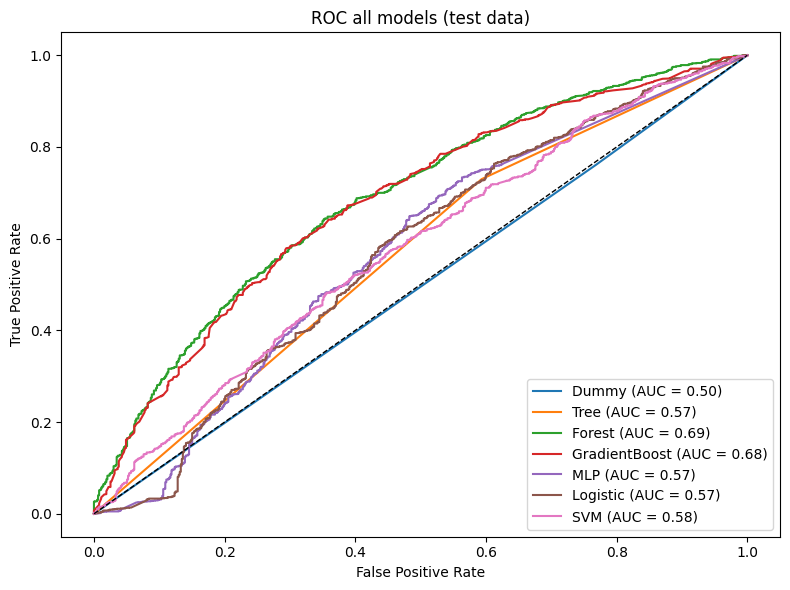

In [149]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_all_roc(y_true, proba_dict, title="ROC Vergleich", savepath=None):
    plt.figure(figsize=(8, 6))
    for name, proba in proba_dict.items():
        fpr, tpr, _ = roc_curve(y_true, proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', dpi=150)
        plt.show()
        plt.close()
 
    else:
        plt.show()


# Anwendung:
results_exp7, preds_test, preds_train, proba_test, proba_train, _, _  = MLevalTUD(X_train, X_test, y_train, y_test, conf_ML)

plot_all_roc(
    y_test,
    proba_test,
    title="ROC all models (test data)",
    savepath="graphs/ROC/ROC_all_models_exp7.png"
)

In [150]:
for marker in ['CV', 'SPD', 'DIFFP', 'RD', 'KURT', 'SKEW', 'KSTEST']:
    plt.figure()
    plt.title(marker)
    X = pd.concat([X_train, X_test])
    mybins = np.arange(np.min(X[marker]), np.max(X[marker]),
                       (np.abs(np.min(X[marker])) + np.max(X[marker])) / 10)
    plt.hist(X_train[marker], bins=mybins, label="train", histtype="step")
    plt.hist(X_test[marker], bins=mybins, label="test", histtype="step")
    plt.yscale("log")
    plt.legend()
    plt.savefig(f"graphs/{marker}_exp7_hist.png", dpi=300, bbox_inches='tight')  # <- export
    #plt.show();
    plt.close()

## Experiment 8 (Swiss[2]-Swiss[2]):

In [151]:
data_names = ["swiss2"]
test_data_names = ["swiss2"]

features_ML = ["CV", "SPD", "DIFFP", "RD", "KURT", "SKEW", "KSTEST"]
conf = pd.read_json("MLresults/MLreanalysis/exp8_nbids_comp.json")
conf.head(7)

,algorithm,train_f1,test_f1,train_precision,test_precision,train_recall,test_recall,train_accuracy,test_accuracy,params
0,Dummy,0.764,0.753,0.762,0.755,0.766,0.752,0.638,0.624,"{'Dummy__random_state': 23, 'Dummy__strategy':..."
1,Tree,0.866,0.866,0.764,0.764,1.000,1.000,0.764,0.764,"{'Tree__max_depth': 1, 'Tree__random_state': 23}"
2,Forest,0.883,0.870,0.794,0.780,0.994,0.986,0.799,0.776,"{'Forest__max_depth': 5, 'Forest__random_state..."
3,GradientBoost,0.871,0.869,0.773,0.772,0.996,0.994,0.774,0.772,"{'GradientBoost__max_depth': 1, 'GradientBoost..."
4,MLP,0.866,0.866,0.764,0.764,1.000,1.000,0.764,0.764,"{'MLP__hidden_layer_sizes': 1, 'MLP__random_st..."
5,Logistic,0.864,0.863,0.767,0.766,0.989,0.989,0.762,0.761,"{'Logistic__C': 59.9484250319, 'Logistic__rand..."
6,SVM,0.916,0.867,0.852,0.779,0.990,0.976,0.861,0.770,"{'SVM__C': 1.0, 'SVM__gamma': 5.9948425032, 'S..."


In [152]:
conf_ML = [
    ('Dummy', DummyClassifier(), conf.params[conf.algorithm == "Dummy"].tolist()[0]),
    ('Tree', DecisionTreeClassifier(), conf.params[conf.algorithm == "Tree"].tolist()[0]),
    ('Forest', RandomForestClassifier(),conf.params[conf.algorithm == "Forest"].tolist()[0]),
    ('GradientBoost', GradientBoostingClassifier(), conf.params[conf.algorithm == "GradientBoost"].tolist()[0]),
    ('MLP', MLPClassifier(), conf.params[conf.algorithm == "MLP"].tolist()[0]),
    ('Logistic', LogisticRegression(), conf.params[conf.algorithm == "Logistic"].tolist()[0]),
    ('SVM', SVC(), conf.params[conf.algorithm == "SVM"].tolist()[0])
]

In [153]:
X_train, X_test, y_train, y_test = prepare_data_eval(data_names, test_data_names)

  0%|          | 0/1 [00:00<?, ?it/s]

9942
loaded train data...


  0%|          | 0/1 [00:00<?, ?it/s]

9942
loaded test data...


/tmp/ipykernel_2679442/1597553833.py:87: RuntimeWarning: invalid value encountered in divide
  df_grouped_train["Bid_value"] = df_grouped_train.Bid_value.apply(lambda x: (np.asarray(x)-min(np.asarray(x)))/np.std(np.asarray(x)))
/tmp/ipykernel_2679442/1597553833.py:89: RuntimeWarning: invalid value encountered in divide
  df_grouped_test["Bid_value"] = df_grouped_test.Bid_value.apply(lambda x: (np.asarray(x)-min(np.asarray(x)))/np.std(np.asarray(x)))


In [154]:
print("Imbalance train:", y_train.sum()/len(y_train))
print("Imbalance test:", y_test.sum()/len(y_test))

Imbalance train: 0.7090239410681399
Imbalance test: 0.7090239410681399


In [155]:
results_exp8, preds_test, preds_train, proba_test, proba_train, y_pred, y_pred_train  = MLevalTUD(X_train, X_test, y_train, y_test, conf_ML)


In [156]:
y_pred_train.sum()/len(y_pred_train)

np.float64(0.8080110497237569)

In [157]:
results_exp8.head(7)

,algorithm,F1,F1_train,precision,precision_train,recall,recall_train,accuracy,accuracy_train,params
0,Dummy,0.714,0.714,0.709,0.709,0.718,0.718,0.591,0.591,"{'Dummy__random_state': 23, 'Dummy__strategy':..."
1,Tree,0.815,0.815,0.768,0.768,0.868,0.868,0.721,0.721,"{'Tree__max_depth': 1, 'Tree__random_state': 23}"
2,Forest,0.854,0.854,0.781,0.781,0.942,0.942,0.772,0.772,"{'Forest__max_depth': 5, 'Forest__random_state..."
3,GradientBoost,0.831,0.831,0.757,0.757,0.921,0.921,0.734,0.734,"{'GradientBoost__max_depth': 1, 'GradientBoost..."
4,MLP,0.830,0.830,0.709,0.709,1.000,1.000,0.709,0.709,"{'MLP__hidden_layer_sizes': 1, 'MLP__random_st..."
5,Logistic,0.830,0.830,0.710,0.710,0.999,0.999,0.710,0.710,"{'Logistic__C': 59.9484250319, 'Logistic__rand..."
6,SVM,0.871,0.871,0.818,0.818,0.932,0.932,0.804,0.804,"{'SVM__C': 1.0, 'SVM__gamma': 5.9948425032, 'S..."


In [158]:
print(results_exp8.to_latex(index=False))  

\begin{tabular}{llllllllll}
\toprule
algorithm & F1 & F1_train & precision & precision_train & recall & recall_train & accuracy & accuracy_train & params \\
\midrule
Dummy & 0.714 & 0.714 & 0.709 & 0.709 & 0.718 & 0.718 & 0.591 & 0.591 & {'Dummy__random_state': 23, 'Dummy__strategy': 'stratified'} \\
Tree & 0.815 & 0.815 & 0.768 & 0.768 & 0.868 & 0.868 & 0.721 & 0.721 & {'Tree__max_depth': 1, 'Tree__random_state': 23} \\
Forest & 0.854 & 0.854 & 0.781 & 0.781 & 0.942 & 0.942 & 0.772 & 0.772 & {'Forest__max_depth': 5, 'Forest__random_state': 23} \\
GradientBoost & 0.831 & 0.831 & 0.757 & 0.757 & 0.921 & 0.921 & 0.734 & 0.734 & {'GradientBoost__max_depth': 1, 'GradientBoost__random_state': 23} \\
MLP & 0.830 & 0.830 & 0.709 & 0.709 & 1.000 & 1.000 & 0.709 & 0.709 & {'MLP__hidden_layer_sizes': 1, 'MLP__random_state': 23} \\
Logistic & 0.830 & 0.830 & 0.710 & 0.710 & 0.999 & 0.999 & 0.710 & 0.710 & {'Logistic__C': 59.9484250319, 'Logistic__random_state': 23} \\
SVM & 0.871 & 0.871 & 0.818 

In [159]:
results_exp8, preds_test, preds_train,_, _, _, _  = MLevalTUD(X_train, X_test, y_train, y_test, conf_ML)


for modelname in preds_test:
    print(f"\nConfusion Matrix für {modelname} (Testdaten):")
    print(confusion_matrix(y_test, preds_test[modelname]))

for modelname in preds_test:
    plot_confusion(
        y_test,
        preds_test[modelname],
        title=f"{modelname} – Test Confusion Matrix",
        filename=f"graphs/confusion_matrix/confmatrix_exp8_{modelname}.png"
    )


Confusion Matrix für Dummy (Testdaten):
[[ 178  454]
 [ 434 1106]]

Confusion Matrix für Tree (Testdaten):
[[ 229  403]
 [ 203 1337]]

Confusion Matrix für Forest (Testdaten):
[[ 226  406]
 [  89 1451]]

Confusion Matrix für GradientBoost (Testdaten):
[[ 177  455]
 [ 122 1418]]

Confusion Matrix für MLP (Testdaten):
[[   0  632]
 [   0 1540]]

Confusion Matrix für Logistic (Testdaten):
[[   4  628]
 [   1 1539]]

Confusion Matrix für SVM (Testdaten):
[[ 312  320]
 [ 105 1435]]


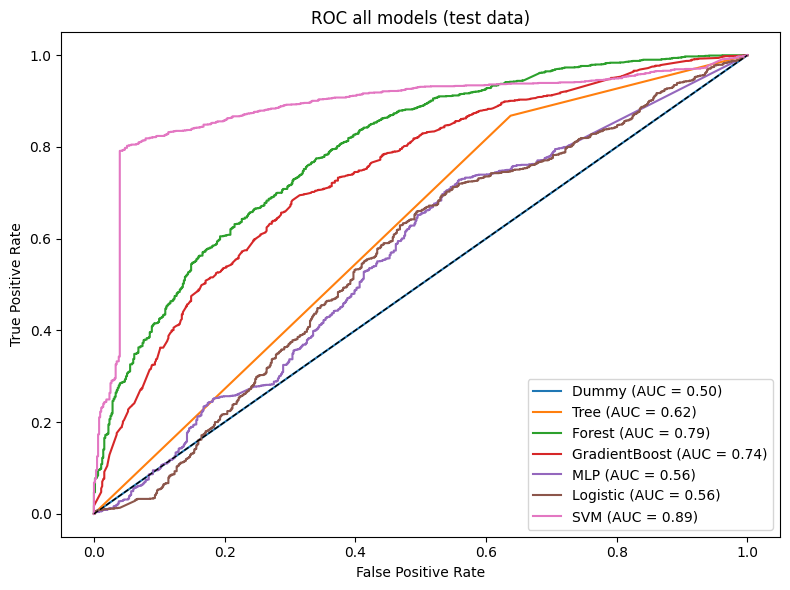

In [160]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_all_roc(y_true, proba_dict, title="ROC Vergleich", savepath=None):
    plt.figure(figsize=(8, 6))
    for name, proba in proba_dict.items():
        fpr, tpr, _ = roc_curve(y_true, proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', dpi=150)
        plt.show()
        plt.close()
 
    else:
        plt.show()


# Anwendung:
results_exp8, preds_test, preds_train, proba_test, proba_train, _, _  = MLevalTUD(X_train, X_test, y_train, y_test, conf_ML)

plot_all_roc(
    y_test,
    proba_test,
    title="ROC all models (test data)",
    savepath="graphs/ROC/ROC_all_models_exp8.png"
)

In [161]:
for marker in ['CV', 'SPD', 'DIFFP', 'RD', 'KURT', 'SKEW', 'KSTEST']:
    plt.figure()
    plt.title(marker)
    X = pd.concat([X_train, X_test])
    mybins = np.arange(np.min(X[marker]), np.max(X[marker]),
                       (np.abs(np.min(X[marker])) + np.max(X[marker])) / 10)
    plt.hist(X_train[marker], bins=mybins, label="train", histtype="step")
    plt.hist(X_test[marker], bins=mybins, label="test", histtype="step")
    plt.yscale("log")
    plt.legend()
    plt.savefig(f"graphs/{marker}_exp8_hist.png", dpi=300, bbox_inches='tight')  # <- export
    #plt.show();
    plt.close()

## Experiment 9 (Swiss-Swiss[2]):

In [162]:
data_names = ["swiss"]
test_data_names = ["swiss2"]

features_ML = ["CV", "SPD", "DIFFP", "RD", "KURT", "SKEW", "KSTEST"]
conf = pd.read_json("MLresults/MLreanalysis/exp8_nbids_comp.json")
conf.head(7)

,algorithm,train_f1,test_f1,train_precision,test_precision,train_recall,test_recall,train_accuracy,test_accuracy,params
0,Dummy,0.764,0.753,0.762,0.755,0.766,0.752,0.638,0.624,"{'Dummy__random_state': 23, 'Dummy__strategy':..."
1,Tree,0.866,0.866,0.764,0.764,1.000,1.000,0.764,0.764,"{'Tree__max_depth': 1, 'Tree__random_state': 23}"
2,Forest,0.883,0.870,0.794,0.780,0.994,0.986,0.799,0.776,"{'Forest__max_depth': 5, 'Forest__random_state..."
3,GradientBoost,0.871,0.869,0.773,0.772,0.996,0.994,0.774,0.772,"{'GradientBoost__max_depth': 1, 'GradientBoost..."
4,MLP,0.866,0.866,0.764,0.764,1.000,1.000,0.764,0.764,"{'MLP__hidden_layer_sizes': 1, 'MLP__random_st..."
5,Logistic,0.864,0.863,0.767,0.766,0.989,0.989,0.762,0.761,"{'Logistic__C': 59.9484250319, 'Logistic__rand..."
6,SVM,0.916,0.867,0.852,0.779,0.990,0.976,0.861,0.770,"{'SVM__C': 1.0, 'SVM__gamma': 5.9948425032, 'S..."


In [163]:
conf_ML = [
    ('Dummy', DummyClassifier(), conf.params[conf.algorithm == "Dummy"].tolist()[0]),
    ('Tree', DecisionTreeClassifier(), conf.params[conf.algorithm == "Tree"].tolist()[0]),
    ('Forest', RandomForestClassifier(),conf.params[conf.algorithm == "Forest"].tolist()[0]),
    ('GradientBoost', GradientBoostingClassifier(), conf.params[conf.algorithm == "GradientBoost"].tolist()[0]),
    ('MLP', MLPClassifier(), conf.params[conf.algorithm == "MLP"].tolist()[0]),
    ('Logistic', LogisticRegression(), conf.params[conf.algorithm == "Logistic"].tolist()[0]),
    ('SVM', SVC(), conf.params[conf.algorithm == "SVM"].tolist()[0])
]

In [164]:
X_train, X_test, y_train, y_test = prepare_data_eval(data_names, test_data_names)

  0%|          | 0/1 [00:00<?, ?it/s]

21231
loaded train data...


  0%|          | 0/1 [00:00<?, ?it/s]

9942
loaded test data...


/tmp/ipykernel_2679442/1597553833.py:87: RuntimeWarning: invalid value encountered in divide
  df_grouped_train["Bid_value"] = df_grouped_train.Bid_value.apply(lambda x: (np.asarray(x)-min(np.asarray(x)))/np.std(np.asarray(x)))
/tmp/ipykernel_2679442/1597553833.py:89: RuntimeWarning: invalid value encountered in divide
  df_grouped_test["Bid_value"] = df_grouped_test.Bid_value.apply(lambda x: (np.asarray(x)-min(np.asarray(x)))/np.std(np.asarray(x)))


In [165]:
print("Imbalance train:", y_train.sum()/len(y_train))
print("Imbalance test:", y_test.sum()/len(y_test))

Imbalance train: 0.7364180478821363
Imbalance test: 0.7090239410681399


In [166]:
results_exp9, preds_test, preds_train, proba_test, proba_train, y_pred, y_pred_train  = MLevalTUD(X_train, X_test, y_train, y_test, conf_ML)


In [167]:
y_pred_train.sum()/len(y_pred_train)

np.float64(0.8756906077348067)

In [168]:
results_exp9.head(7)

,algorithm,F1,F1_train,precision,precision_train,recall,recall_train,accuracy,accuracy_train,params
0,Dummy,0.723,0.747,0.708,0.741,0.740,0.753,0.599,0.625,"{'Dummy__random_state': 23, 'Dummy__strategy':..."
1,Tree,0.830,0.848,0.709,0.736,1.000,1.000,0.709,0.736,"{'Tree__max_depth': 1, 'Tree__random_state': 23}"
2,Forest,0.843,0.861,0.742,0.768,0.976,0.981,0.742,0.767,"{'Forest__max_depth': 5, 'Forest__random_state..."
3,GradientBoost,0.832,0.852,0.725,0.753,0.975,0.982,0.721,0.750,"{'GradientBoost__max_depth': 1, 'GradientBoost..."
4,MLP,0.830,0.848,0.709,0.736,1.000,1.000,0.709,0.736,"{'MLP__hidden_layer_sizes': 1, 'MLP__random_st..."
5,Logistic,0.831,0.849,0.711,0.737,0.999,1.000,0.711,0.738,"{'Logistic__C': 59.9484250319, 'Logistic__rand..."
6,SVM,0.858,0.874,0.787,0.804,0.944,0.956,0.779,0.796,"{'SVM__C': 1.0, 'SVM__gamma': 5.9948425032, 'S..."


In [169]:
print(results_exp9.to_latex(index=False))

\begin{tabular}{llllllllll}
\toprule
algorithm & F1 & F1_train & precision & precision_train & recall & recall_train & accuracy & accuracy_train & params \\
\midrule
Dummy & 0.723 & 0.747 & 0.708 & 0.741 & 0.740 & 0.753 & 0.599 & 0.625 & {'Dummy__random_state': 23, 'Dummy__strategy': 'stratified'} \\
Tree & 0.830 & 0.848 & 0.709 & 0.736 & 1.000 & 1.000 & 0.709 & 0.736 & {'Tree__max_depth': 1, 'Tree__random_state': 23} \\
Forest & 0.843 & 0.861 & 0.742 & 0.768 & 0.976 & 0.981 & 0.742 & 0.767 & {'Forest__max_depth': 5, 'Forest__random_state': 23} \\
GradientBoost & 0.832 & 0.852 & 0.725 & 0.753 & 0.975 & 0.982 & 0.721 & 0.750 & {'GradientBoost__max_depth': 1, 'GradientBoost__random_state': 23} \\
MLP & 0.830 & 0.848 & 0.709 & 0.736 & 1.000 & 1.000 & 0.709 & 0.736 & {'MLP__hidden_layer_sizes': 1, 'MLP__random_state': 23} \\
Logistic & 0.831 & 0.849 & 0.711 & 0.737 & 0.999 & 1.000 & 0.711 & 0.738 & {'Logistic__C': 59.9484250319, 'Logistic__random_state': 23} \\
SVM & 0.858 & 0.874 & 0.787 

In [170]:
results_exp9, preds_test, preds_train,_, _, _, _  = MLevalTUD(X_train, X_test, y_train, y_test, conf_ML)


for modelname in preds_test:
    print(f"\nConfusion Matrix für {modelname} (Testdaten):")
    print(confusion_matrix(y_test, preds_test[modelname]))

for modelname in preds_test:
    plot_confusion(
        y_test,
        preds_test[modelname],
        title=f"{modelname} – Test Confusion Matrix",
        filename=f"graphs/confusion_matrix/confmatrix_exp9_{modelname}.png"
    )


Confusion Matrix für Dummy (Testdaten):
[[ 162  470]
 [ 401 1139]]

Confusion Matrix für Tree (Testdaten):
[[   0  632]
 [   0 1540]]

Confusion Matrix für Forest (Testdaten):
[[ 109  523]
 [  37 1503]]

Confusion Matrix für GradientBoost (Testdaten):
[[  64  568]
 [  39 1501]]

Confusion Matrix für MLP (Testdaten):
[[   0  632]
 [   0 1540]]

Confusion Matrix für Logistic (Testdaten):
[[   5  627]
 [   1 1539]]

Confusion Matrix für SVM (Testdaten):
[[ 239  393]
 [  87 1453]]


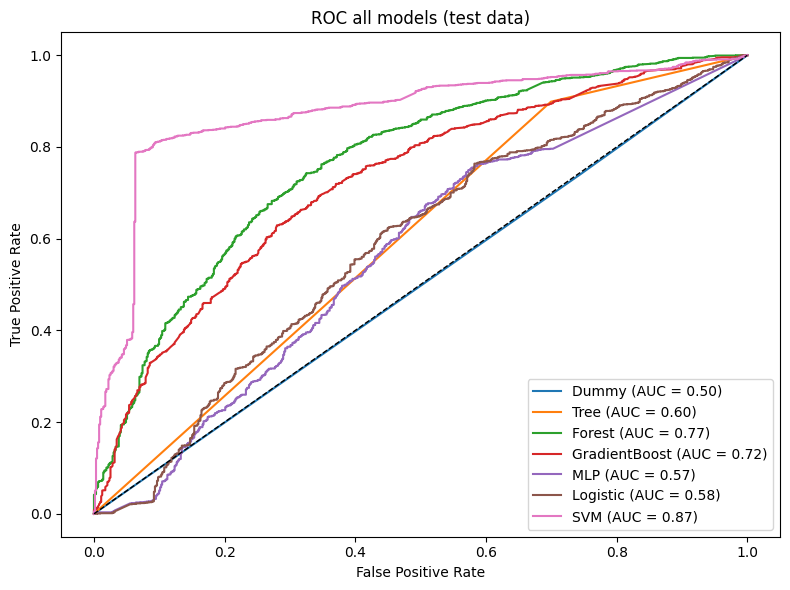

In [171]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_all_roc(y_true, proba_dict, title="ROC Vergleich", savepath=None):
    plt.figure(figsize=(8, 6))
    for name, proba in proba_dict.items():
        fpr, tpr, _ = roc_curve(y_true, proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', dpi=150)
        plt.show()
        plt.close()
 
    else:
        plt.show()


# Anwendung:
results_exp9, preds_test, preds_train, proba_test, proba_train, _, _  = MLevalTUD(X_train, X_test, y_train, y_test, conf_ML)

plot_all_roc(
    y_test,
    proba_test,
    title="ROC all models (test data)",
    savepath="graphs/ROC/ROC_all_models_exp9.png"
)

In [172]:
for marker in ['CV', 'SPD', 'DIFFP', 'RD', 'KURT', 'SKEW', 'KSTEST']:
    plt.figure()
    plt.title(marker)
    X = pd.concat([X_train, X_test])
    mybins = np.arange(np.min(X[marker]), np.max(X[marker]),
                       (np.abs(np.min(X[marker])) + np.max(X[marker])) / 10)
    plt.hist(X_train[marker], bins=mybins, label="train", histtype="step")
    plt.hist(X_test[marker], bins=mybins, label="test", histtype="step")
    plt.yscale("log")
    plt.legend()
    plt.savefig(f"graphs/{marker}_exp9_hist.png", dpi=300, bbox_inches='tight')  # <- export
    #plt.show();
    plt.close()